<a href="https://colab.research.google.com/github/WaiWasabi/math-modeling/blob/main/mams_coal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Program Overview

The simulation employs an object-oriented method which formulates the components of the problem as subclasses of the Component "interface". Each subclass (train, high capacity train, and tipple) have an update function, a terminal condition, and vars {state, fee, capacity, increment}. The Scheduler class effectively iterates over time, "step," instantiating new objects when necessary and keeping track of all fees.

# How to Use It?

Run the first couple of cells.

The Scheduler class can be instantiated with the call Scheduler(std_arrivals, hc_arrival=None, period=15, step=1, num=2). 
- std_arrivals -> list of values between 0 and 1 representing when the repective train arrives at the station within the provided time window.
- hc_arrival -> a value between 0 and 1 representing the arrival of the high capacity train within the allowed time window, if specified.
- period -> the time window
- step -> amount of times the program updates per hour. Increasing this number gives better precision and is a more accurate model of continuous time.
- num -> number of crews employed in the operation (must be constant throughout workday in current model).

In [2]:
class Component: # default settings for Train class.
  def __init__(self, step):
    self.state = 0
    self.fee = 15000 / step  # fee per step
    self.increment = 1
    self.capacity = 3 * step
  
  def update(self):
    self.state += self.increment
  
  def terminate(self):
    return self.state >= self.capacity

  def isEmpty(self):
    return self.state < 4

  def getCurrFee(self):
    return 0

class Train(Component):
  def __init__(self, step):
    super().__init__(step)

class HCTrain(Train):
  def __init__(self, step):
    super().__init__(step)
    self.capacity *= 2
    self.fee = 25000 / step

class Tipple(Component):
  def __init__(self, step, num=1):
    fees = [9000, 12000, 12000]
    super().__init__(step)
    self.capacity = 18 * step # scaled to real numbers
    self.state = self.capacity
    self.fee = sum(fees[:num]) / step
    self.increment = 3 * num
  
  def terminate(self):
    return self.state >= 1

  def update(self):
    self.state =  min(self.capacity, self.state + self.increment)

  def getCurrFee(self):
    return self.fee

In [5]:
import numpy as np

class Scheduler:
  def __init__(self, std_arrivals, hc_arrival=None, period=15, step=1, num=2):
    self.step = step
    self.meta = self.getMetadata(std_arrivals, hc_arrival, period)
    self.arrivals = iter(self.meta)
    self.demurrage, self.loading_fee, self.current, self.q = 0, 0, None, []
    self.tipple = Tipple(step, num)
    watch = next(self.arrivals)
    for t in range(period*step + 24):
      while t == watch[0]:  # add all arriving trains to the queue
          self.addTrain(watch[1], step)
          watch = next(self.arrivals, (-1, -1))  # (-1, -1) default case for iter end
      self.update()  # update state of system
      self.loading_fee += self.current.getCurrFee()
      self.demurrage += sum([train.fee for train in self.q])
      self.current = None if self.current.terminate() else self.current

  def addTrain(self, value, step):
    classes = [Train, HCTrain]
    self.q.append(classes[int(value)](step))

  def update(self):  # casework
    if self.current == None and len(self.q) != 0:
      self.current = self.q.pop(0)
    if self.tipple.isEmpty() and (type(self.current) == Train or type(self.current) == HCTrain):
      self.q.insert(0, self.current)
      self.current = None
    if self.current is None:
      self.current = self.tipple
    self.current.update()
    if self.current != self.tipple:  # this is okay because current is always either tipple or train
      self.tipple.state -= 4

  def toHours(self, x):
    return x/self.step

  def toSteps(self, x):
    return x*self.step
  
  def getMetadata(self, std_arrivals, hc_arrival, period):
    arrivals = list(zip(np.multiply(period, std_arrivals), len(std_arrivals)*[0]))
    if hc_arrival is not None:
      arrivals.append([hc_arrival * self.toSteps(2) + self.toSteps(6), 1])
    x = np.array(arrivals)
    return np.rint(x[x[:,0].argsort()])

In [6]:
thursdays = []  # demurrage (loading fee constant)
stuff = []
for i in range(10000):
  std = np.random.random(3)
  hc = np.random.random(1)[0]
  s = Scheduler(std, hc, num=2)
  thursdays.append(s.demurrage)
  if s.demurrage < 150000:
    stuff.append(s)

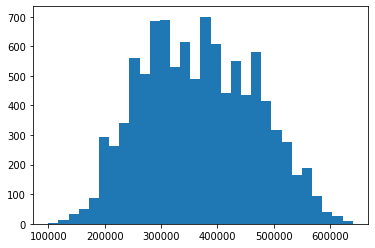


minimum:  100000.0


In [7]:
import matplotlib.pyplot as plt

plt.hist(thursdays, bins=30)
plt.show()

print("\nminimum: ", min(thursdays))

In [8]:
import math
print("monte carlo average:", (sum(thursdays)/len(thursdays)))
print("% improvement:", (sum(thursdays)/len(thursdays)-100000)/(sum(thursdays)/len(thursdays)) * 100)

monte carlo average: 366314.5
% improvement: 72.70105332985727


In [ ]:
x = Scheduler([0, 1, 1], 0, num=2)
x.demurrage

100000.0